<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/single_cell_after_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial: Quick single-cell transcriptomics using GPU UMAP analysis & visualization

Using GPU-accelerated UMAP analysis & visualization, single cell data can be analyzed faster and much more easily explored.

* Task: Analyze single cell's gene expression for clustering
* Data: 5 independent datasets of roughly 30K rows of 200 columns of single cell
* [data](https://cytotrace.stanford.edu/#shiny-tab-dataset_download)
* [paper](https://arxiv.org/pdf/2208.05229.pdf)

**Insight/ Result:**

1.   over 5x faster for entire ~10000 cell samples (102s vs 18s)
3.   Offers more insight when static plot would otherwise fail


(See also: [CPU baseline](https://github.com/dcolinmorgan/grph/blob/main/standard_single_cell_umap_demo.ipynb))

## Setup

(install cuda packages first)

### install

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu11 cudf-cu11 cugraph-cu11 pylibraft_cu11 raft_dask_cu11 dask_cudf_cu11 pylibcugraph_cu11 pylibraft_cu11
import cuml,cudf
print(cuml.__version__)

!pip install -U --force git+https://github.com/graphistry/pygraphistry.git@feat/gpu-featurization
!pip install -U git+https://github.com/graphistry/cu-cat.git@DT4
# !pip install dirty_cat

!pip install Biopython

!nvidia-smi

!pip install scanpy

### import / configure

#### get a free api-key at https://www.graphistry.com/

In [2]:
import scanpy as sc
import anndata

import graphistry
graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='fXjJnkE3Gik6BWy') ## key id, secret key

# graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='***') ## key id, secret key
graphistry.__version__


'0.29.1+6.gc1bc6f1'

In [ ]:
!nvidia-smi

In [4]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !git clone https://github.com/dcolinmorgan/rapidsai-csp-utils/tree/patch-1
# !python rapidsai-csp-utils/colab/pip-install.py

import cuml
cuml.__version__

# import cupy
# cudf.__version__

'23.06.00'

In [5]:
import os, time
from collections import Counter
import cProfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pstats import Stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)

## Data Download & Description

In [6]:
#download 6 single cell datasets
%%bash
wget -nc -q https://www.dropbox.com/s/h1k7jy0kad6fguu/GSE107910_40.h5ad.zip
wget -nc -q https://www.dropbox.com/s/xza477kxj7vgdlr/GSE67123_6.h5ad.zip

unzip -o GSE107910_40.h5ad.zip
unzip -o GSE67123_6.h5ad.zip

mkdir -p single_cell
mv *.h5ad single_cell

Archive:  GSE107910_40.h5ad.zip
  inflating: GSE107910_40.h5ad       
Archive:  GSE67123_6.h5ad.zip
  inflating: GSE67123_6.h5ad         


In [7]:

list_files = []
for dirname, _, filenames in os.walk('single_cell'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        list_files.append(os.path.join(dirname, filename))

for fn in list_files:
    adata = sc.read(fn) # sc.read_h5ad
    print( adata.uns['info'] )
    print()

['Thymus (Drop-seq)' 'Validation' '15429' '9307.0' 'nan' '9307' '19530'
 '8' '8' 'UMI' 'Mouse' '1' 'Thymus' 'Drop-seq' 'Timepoints' 'in vivo'
 '29884461' '20180619' 'GSE107910' 'Immunity'
 'Only hematopoietic cells, selected based on detectable Ptprc expression, were considered in this dataset. ']

['Embryonic HSCs (Tang et al.)' 'Validation' '143' 'nan' 'nan' '143'
 '24028' '5' '5' 'TPM/FPKM' 'Mouse' '1' 'Embryo' 'Tang et al.'
 'Timepoints' 'in vivo' '27225119' '20160526' 'GSE67123' 'Nature' 'nan']



# scanpy read and compute UMAP for GSE107910_40 Murine Thymus cells




In [19]:
fn='single_cell/GSE107910_40.h5ad'
adata = sc.read(fn) # sc.read_h5ad
str_data_inf = fn.split('/')[1].split('.')[0] + ' ' + str(adata.X.shape)+'\n' + adata.uns['info'][0]

EE=pd.DataFrame(adata.X,columns=adata.uns['gcsGenesNames'],index=adata.uns['allcellnames'])
g1=graphistry.nodes(cudf.from_pandas(EE.T))#.reset_index(),"index") #,columns=adata1.uns['gcsGenesNames']))

t0 = time.time()

g11 = g1.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )

print('Total ', np.round(time.time() - t0,1), 'seconds passed')


Total  27.5 seconds passed


In [21]:
emb2=g11._node_embedding

A=emb2.reset_index()['index'].to_pandas()#.str.split('|').str[6]#.str.split('|').str[0]#+'_'+data2.Donor
emb2.index=A

B=g11._edges
B['_src_implicit'] = B['_src_implicit'].replace(A, regex=True)#apply(lambda x: [A[i] for i in x])
B['_dst_implicit'] = B['_dst_implicit'].replace(A, regex=True)

# g3._edges[g3._edges['_src_implicit']!=g3._edges['_dst_implicit']]
g22=graphistry.nodes(emb2.reset_index(),'index').edges(g11._edges.dropna(),'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})

g22.plot()

## this paper was specifically interested in peak mitosis genes, ie ["Tirosh" genes](https://genome.cshlp.org/content/25/12/1860.short), so lets zoom in on those

In [23]:
S_phase_genes_Tirosh = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
G2_M_genes_Tirosh = ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']
u = 'allgenenames'
list_genes_upper = [t.upper() for t in adata.uns[u] ]
I = np.where( pd.Series(list_genes_upper).isin( S_phase_genes_Tirosh + G2_M_genes_Tirosh ) )[0]


In [28]:
EE=pd.DataFrame(adata.X[:,I],columns=adata.uns['gcsGenesNames'][I],index=adata.uns['allcellnames'])
g1=graphistry.nodes(cudf.from_pandas(EE.T)) #,columns=adata1.uns['gcsGenesNames']))

t0 = time.time()

g11 = g1.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )


print('Total ', np.round(time.time() - t0,1), 'seconds passed')


Total  12.5 seconds passed


In [29]:
emb2=g11._node_embedding

A=emb2.reset_index()['index'].to_pandas()#.str.split('|').str[6]#.str.split('|').str[0]#+'_'+data2.Donor
emb2.index=A

B=g11._edges
B['_src_implicit'] = B['_src_implicit'].replace(A, regex=True)#apply(lambda x: [A[i] for i in x])
B['_dst_implicit'] = B['_dst_implicit'].replace(A, regex=True)

# g3._edges[g3._edges['_src_implicit']!=g3._edges['_dst_implicit']]
g22=graphistry.nodes(emb2.reset_index(),'index').edges(g11._edges.dropna(),'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})

g22.plot()

# bonus round: GSE67123_6 Embryonic HSCs



*   static, pre-computed phenotype t-SNE and UMAP are not so telling...



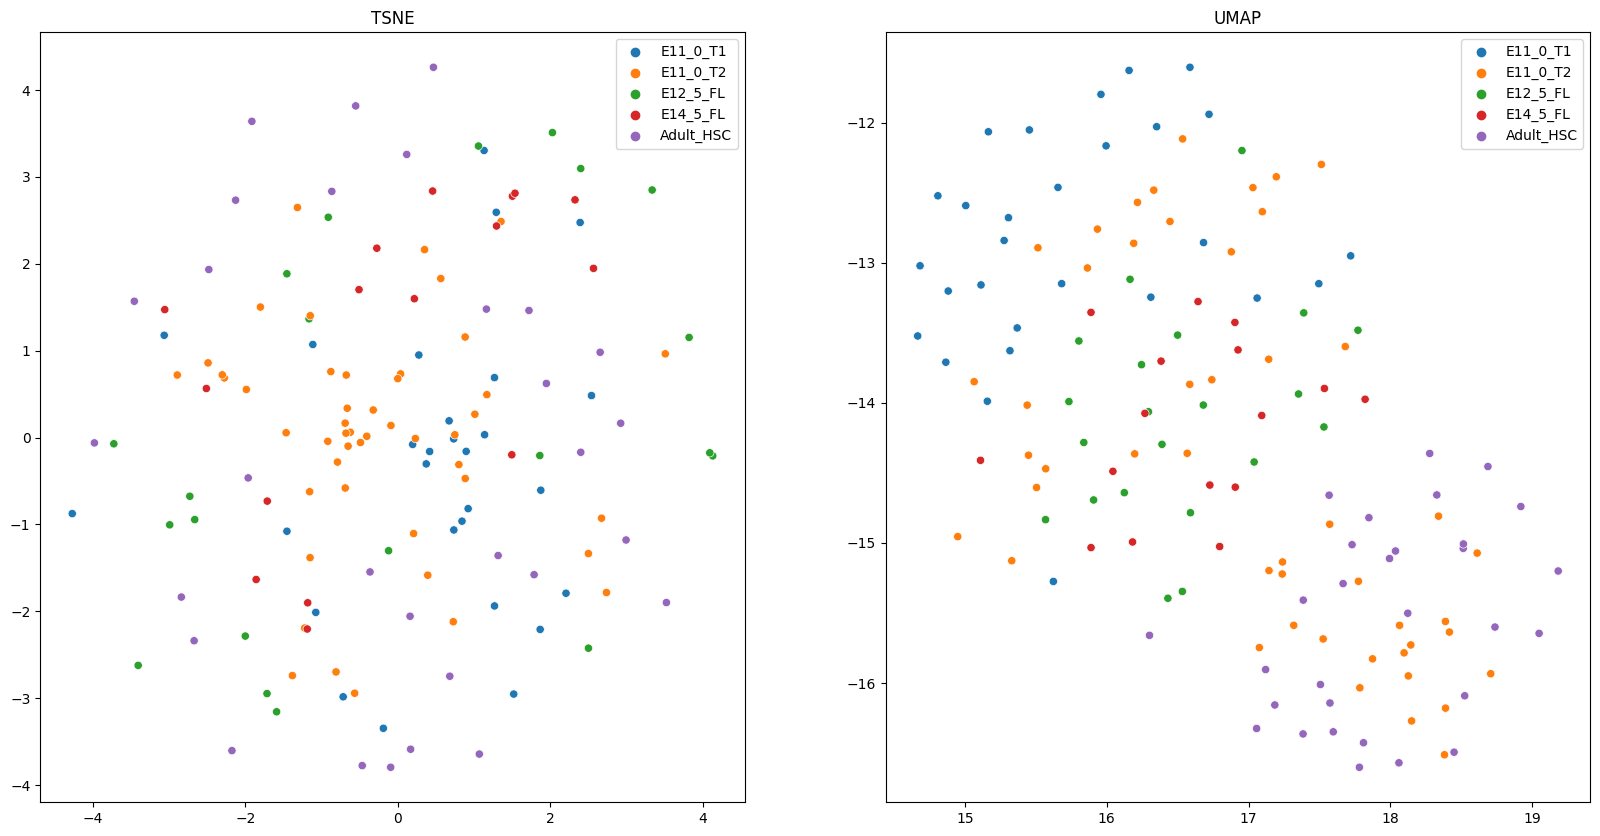

In [33]:
fig,ax = plt.subplots(1,2, figsize = (20,10)); c = 0
ax[0].set_title('TSNE')
ax[1].set_title('UMAP')
# plt.suptitle(' all genes ' +str_data_inf_2 + ' Shape: ' + str(adata2.X.shape) , fontsize = 20  )
fn='single_cell/GSE67123_6.h5ad'
adata2 = sc.read(fn) # sc.read_h5ad

sns.scatterplot(x = adata2.uns['X_tsne'][:,0], y = adata2.uns['X_tsne'][:,1]  , hue = adata2.uns['Phenotype'],ax=ax[0])

sns.scatterplot(x = adata2.uns['X_umap'][:,0], y = adata2.uns['X_umap'][:,1]  , hue = adata2.uns['Phenotype'],ax=ax[1])

plt.show()

*   interactive plot of genes allows more thorough investigations -- defining clusters of genes with similar expression



In [42]:
t0 = time.time()

fn='single_cell/GSE67123_6.h5ad'
adata2 = sc.read(fn) # sc.read_h5ad
str_data_inf_2 = fn.split('/')[1].split('.')[0] + ' ' + str(adata2.X.shape)+'\n' + adata2.uns['info'][0]

EE=pd.DataFrame(adata2.X,columns=adata2.uns['gcsGenesNames'],index=adata2.uns['allcellnames'])
g2=graphistry.nodes(cudf.from_pandas(EE.T))#,columns=adata1.uns['gcsGenesNames']))

g22 = g2.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )

print('Total ', np.round(time.time() - t0,1), 'seconds passed')

emb2=g22._node_embedding

A=emb2.reset_index()['index'].to_pandas()#.str.split('|').str[6]#.str.split('|').str[0]#+'_'+data2.Donor
emb2.index=A
emb2=emb2[~emb2.index.str.contains('Rik')]

B=g22._edges
B['_src_implicit'] = B['_src_implicit'].replace(A, regex=True)#apply(lambda x: [A[i] for i in x])
B['_dst_implicit'] = B['_dst_implicit'].replace(A, regex=True)

# g3._edges[g3._edges['_src_implicit']!=g3._edges['_dst_implicit']]
g22=graphistry.nodes(emb2.reset_index(),'index').edges(g22._edges.dropna(),'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})

g22.plot()

Total  0.9 seconds passed


*   interactive plot of patients can define clusters of patients where obvious groupings might not be available, ie no disease v heealthy, female v male -- and so enabling comparative genomic analysis.



## metadata would help us distinguish patient umap

In [60]:
len(adata2.uns['allcellnames'])

143

In [61]:
len(adata2.uns['Order'])

143

In [ ]:
t0 = time.time()

# fn='single_cell/GSE67123_6.h5ad'
adata2 = sc.read(fn) # sc.read_h5ad
str_data_inf_2 = fn.split('/')[1].split('.')[0] + ' ' + str(adata2.X.shape)+'\n' + adata2.uns['info'][0]

EE=pd.DataFrame(adata2.X,columns=adata2.uns['gcsGenesNames'],index=adata2.uns['allcellnames'])
g2=graphistry.nodes(cudf.from_pandas(EE))#,columns=adata1.uns['gcsGenesNames']))

g22 = g2.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )

print('Total ', np.round(time.time() - t0,1), 'seconds passed')


emb2=g22._node_embedding

A=emb2.reset_index()['index'].to_pandas()#.str.split('|').str[6]#.str.split('|').str[0]#+'_'+data2.Donor
emb2.index=A
emb2=emb2[~emb2.index.str.contains('Rik')]

B=g22._edges
B['_src_implicit'] = B['_src_implicit'].replace(A, regex=True)#apply(lambda x: [A[i] for i in x])
B['_dst_implicit'] = B['_dst_implicit'].replace(A, regex=True)

# g3._edges[g3._edges['_src_implicit']!=g3._edges['_dst_implicit']]
g22=graphistry.nodes(emb2.reset_index(),'index').edges(g22._edges.dropna(),'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})

g22.plot()